In [1]:
# base
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
import scanpy.api as sc
import scanpy.external
import anndata as ad
import scipy.stats as ss
import sys


#plotting
from plotnine import *
import plotnine
import matplotlib as mp

# ingest data and update labels
adata = sc.read_h5ad('/mnt/ibm_lg/daniel_le/data/covid/comet/TA_COMET_10x.h5ad')

Leiden_1_Type = [
    'Neutrophil', 'Mono/Macro','Epithelial','T/NK','Mono/Macro','Mono/Macro','Mono/Macro','Epithelial','LowQuality','Mono/Macro','Mono/Macro',
    'Epithelial','Mono/Macro','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Mono/Macro','Epithelial','Epithelial',
    'T/NK','Neutrophil', 'Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial',
    'B', 'Epithelial']

leiden_1_dict = {}
for idx, x in enumerate(Leiden_1_Type):
    leiden_1_dict[str(idx)] = x
    
adata.obs['leiden_1_class'] = adata.obs['leiden_1'].map(leiden_1_dict)

# metrics
metrics = ['log1p_n_genes_by_counts', 
           'log1p_total_counts', 
           'pct_counts_in_top_50_genes', 
           'percent_ribo', 
           'percent_mito',
          ]
occupants = ['patientID_415-xxxx']
qc_metrics = ['log1p_n_genes_by_counts', 'percent_mito',]
adata_df = adata.obs.loc[:,metrics+occupants]

# ref: https://github.com/oliviaguest/gini
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    ### FROM scanpy ###
    
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
#     sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def kde_scipy(x, x_grid, bandwidth=0.1, **kwargs):
    """ref = https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/"""
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    try:
        kde = ss.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return_vals = kde.evaluate(x_grid)
    except:
        return_vals = np.zeros(x_grid.shape)
        return_vals[:10] = 1
    return return_vals

/home/daniel_le/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# Low-quality QC

... storing 'leiden_1_class' as categorical


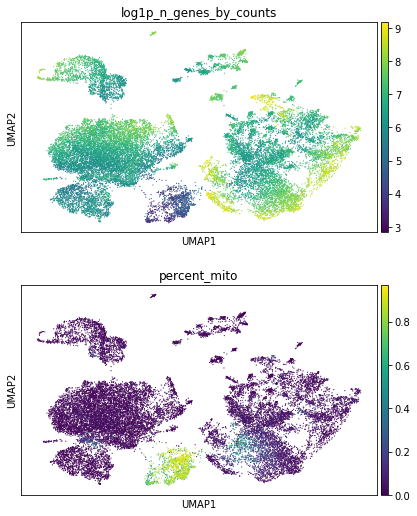

/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 76'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


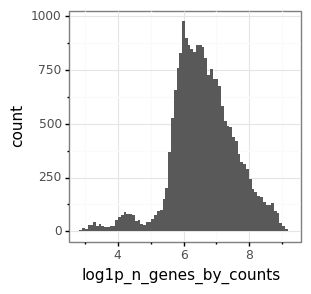

<ggplot: (8728006997205)>


/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 501'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


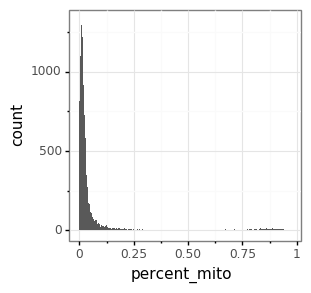

<ggplot: (8728006418437)>


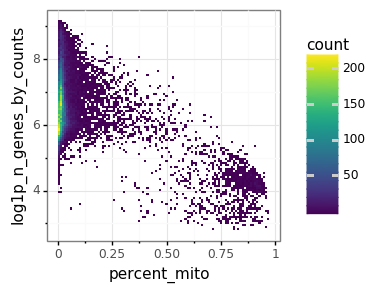

<ggplot: (8728007013613)>


In [2]:
# QC umap
sc.pl.umap(adata, 
           color = qc_metrics,
           ncols = 1
          )

# QC metric histograms
plotnine.options.figure_size = (3,3)
for metric in qc_metrics:
    plot = (ggplot(adata_df)
            + theme_bw()
            + geom_histogram(aes(metric))
           )
    print(plot)
    
# low-quality percent_mito vs log1p_n_genes_by_counts
plot = (ggplot(adata_df)
            + theme_bw()
            + geom_bin2d(aes('percent_mito','log1p_n_genes_by_counts'),bins=100)
           )
print(plot)

# mask low-quality cells

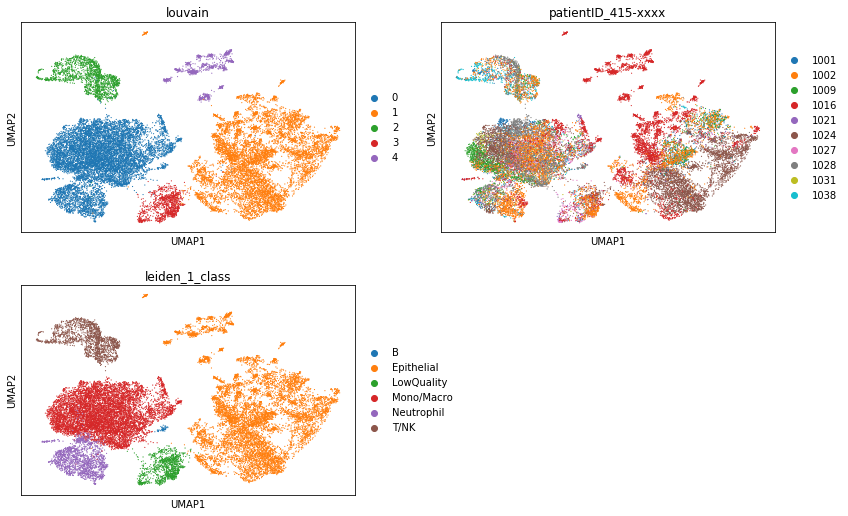

In [3]:
sc.tl.louvain(adata, resolution = 0.05, random_state=1)
sc.pl.umap(adata, 
           color = ['louvain','patientID_415-xxxx','leiden_1_class'],
           ncols = 2
          )
adata.obs['low_quality'] = [x == '3' for x in adata.obs['louvain']]

## parameter search over n_pcs and cluster_res to determine value of bbknn batch correction

In [4]:
# gini_df = pd.DataFrame()

# for n_pcs in [3,4,5,6,7,8,9,10,
#               15,30,45,60]:
#     for cluster_res in [0.025, 0.05, 0.075,0.1, 
#                         0.25, 0.5, 0.75,1.0, 
#                         2.5, 5.0, 7.5, 10]:
        
#         # clustering pipeline
#         adata.X = adata.raw.X.toarray()
#         hq_adata = adata[adata.obs['low_quality'] == False]
#         hq_adata = sc.pp.log1p(hq_adata, copy=True)
#         sc.pp.highly_variable_genes(hq_adata,min_mean=0.1,max_mean=10,min_disp=0.5)
#         sc.pp.scale(hq_adata)
#         sc.tl.pca(hq_adata,svd_solver='arpack', use_highly_variable = True, 
#                   n_comps=n_pcs, random_state=1, zero_center = False)
#         sc.pp.neighbors(hq_adata, n_pcs=n_pcs, n_neighbors=15, random_state=1)
# #         sc.tl.umap(hq_adata, min_dist = 0.5, random_state=1, init_pos='random')
#         sc.tl.leiden(hq_adata, resolution = cluster_res, random_state=1)
#         # sc.pl.umap(hq_adata, color=['leiden','leiden_1_class','patientID_415-xxxx'])

#         # compute patient occupancy gini with uncorrected clusters
#         pat_occ_df = (pd.DataFrame(hq_adata
#                       .obs
#                       .loc[:, ['leiden','patientID_415-xxxx']]
#                       .groupby('leiden')['patientID_415-xxxx']
#                       .value_counts(normalize = True)
#                      )
#               .rename(columns = {'patientID_415-xxxx':'freq'})
#               .reset_index()
#               .rename(columns = {0:'freq'})
#              )
#         uncorrected_gini = gini(pat_occ_df['freq'].values)

#         # bbknn
#         scanpy.external.pp.bbknn(hq_adata, batch_key='patientID_415-xxxx')
# #         sc.tl.umap(hq_adata, min_dist = 0.5, random_state=1, init_pos='random')
#         sc.tl.leiden(hq_adata, resolution = cluster_res, random_state=1)
# #         sc.pl.umap(hq_adata, color=['leiden_1_class','patientID_415-xxxx'])
#         # hq_adata.write('/mnt/ibm_lg/daniel_le/data/covid/comet/TA_COMET_10x_hq_bbknn.h5ad')

#         # compute patient occupancy gini with corrected clusters
#         pat_occ_df = (pd.DataFrame(hq_adata
#                       .obs
#                       .loc[:, ['leiden','patientID_415-xxxx']]
#                       .groupby('leiden')['patientID_415-xxxx']
#                       .value_counts(normalize = True)
#                      )
#               .rename(columns = {'patientID_415-xxxx':'freq'})
#               .reset_index()
#               .rename(columns = {0:'freq'})
#              )
#         corrected_gini = gini(pat_occ_df['freq'].values)
        
#         # update df
#         df_slice = pd.DataFrame({'uncorrected_gini':[uncorrected_gini],
#                                  'corrected_gini':[corrected_gini],
#                                  'n_pcs':[n_pcs],
#                                  'cluster_res':[cluster_res]
#                                 })
#         gini_df = gini_df.append(df_slice)
        
# gini_melt = pd.melt(gini_df, id_vars=['n_pcs','cluster_res'])
# gini_melt['variable'] = (gini_melt['variable']
#                          .astype(str)
#                          .astype(CategoricalDtype(['uncorrected_gini','corrected_gini'], ordered = True))
#                         )


In [5]:
# plotnine.options.figure_size = (4,4)
# plot = (ggplot(gini_melt)
#         + theme_bw()
#         + theme(aspect_ratio = 1,
#                axis_text_x = element_text(angle=90))
#         + geom_tile(aes('factor(n_pcs)',
#                         'factor(cluster_res)',
#                         fill='value'))
#         + facet_wrap('~variable')
#         + scale_fill_cmap('jet')
#        )
# print(plot)

## GOI look up

In [6]:
gini_df = pd.DataFrame()

for n_pcs in [15]:
    for cluster_res in [0.1]:
        
        # clustering pipeline
        adata.X = adata.raw.X.toarray()
        hq_adata = adata[adata.obs['low_quality'] == False]
        hq_adata = sc.pp.log1p(hq_adata, copy=True)
        sc.pp.highly_variable_genes(hq_adata,min_mean=0.1,max_mean=10,min_disp=0.5)
        sc.pp.scale(hq_adata)
        sc.tl.pca(hq_adata,svd_solver='arpack', use_highly_variable = True, 
                  n_comps=n_pcs, random_state=1, zero_center = False)
        sc.pp.neighbors(hq_adata, n_pcs=n_pcs, n_neighbors=15, random_state=1)
        sc.tl.umap(hq_adata, min_dist = 0.5, random_state=1, init_pos='random')
        sc.tl.leiden(hq_adata, resolution = cluster_res, random_state=1)
        # sc.pl.umap(hq_adata, color=['leiden','leiden_1_class','patientID_415-xxxx'])

        # compute patient occupancy gini with uncorrected clusters
        pat_occ_df = (pd.DataFrame(hq_adata
                      .obs
                      .loc[:, ['leiden','patientID_415-xxxx']]
                      .groupby('leiden')['patientID_415-xxxx']
                      .value_counts(normalize = True)
                     )
              .rename(columns = {'patientID_415-xxxx':'freq'})
              .reset_index()
              .rename(columns = {0:'freq'})
             )
        uncorrected_gini = gini(pat_occ_df['freq'].values)

        # bbknn
        scanpy.external.pp.bbknn(hq_adata, batch_key='patientID_415-xxxx')
        sc.tl.umap(hq_adata, min_dist = 0.5, random_state=1, init_pos='random')
        sc.tl.leiden(hq_adata, resolution = cluster_res, random_state=1)
#         sc.pl.umap(hq_adata, color=['leiden_1_class','patientID_415-xxxx'])
        # hq_adata.write('/mnt/ibm_lg/daniel_le/data/covid/comet/TA_COMET_10x_hq_bbknn.h5ad')

        # compute patient occupancy gini with corrected clusters
        pat_occ_df = (pd.DataFrame(hq_adata
                      .obs
                      .loc[:, ['leiden','patientID_415-xxxx']]
                      .groupby('leiden')['patientID_415-xxxx']
                      .value_counts(normalize = True)
                     )
              .rename(columns = {'patientID_415-xxxx':'freq'})
              .reset_index()
              .rename(columns = {0:'freq'})
             )
        corrected_gini = gini(pat_occ_df['freq'].values)
        
        # update df
        df_slice = pd.DataFrame({'uncorrected_gini':[uncorrected_gini],
                                 'corrected_gini':[corrected_gini],
                                 'n_pcs':[n_pcs],
                                 'cluster_res':[cluster_res]
                                })
        gini_df = gini_df.append(df_slice)
        


/home/daniel_le/anaconda3/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/daniel_le/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/utils

In [33]:
[x for x in hq_adata.var_names if x.startswith('IFN')]

['IFNLR1',
 'IFNGR1',
 'IFNB1',
 'IFNE',
 'IFNG-AS1',
 'IFNG',
 'IFNL3',
 'IFNL1',
 'IFNAR2',
 'IFNAR1',
 'IFNGR2']

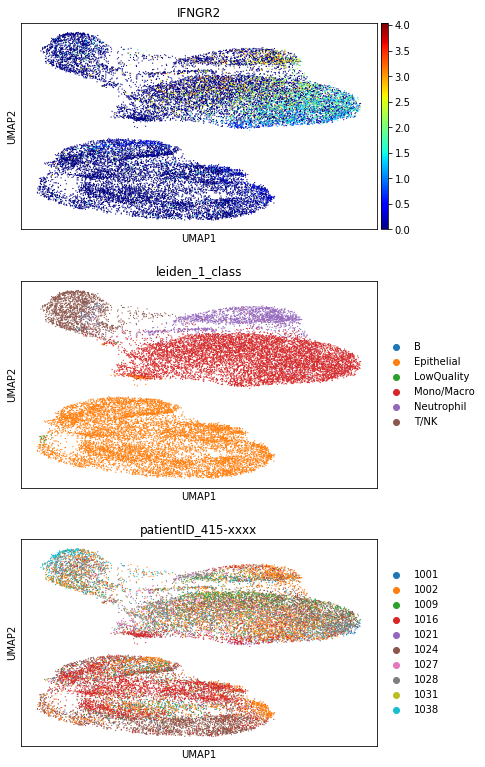

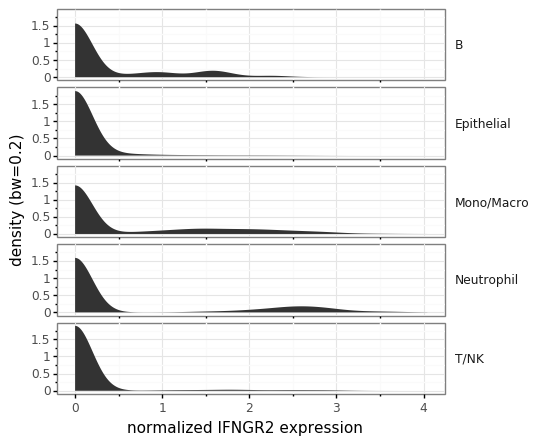

<ggplot: (8728151448145)>


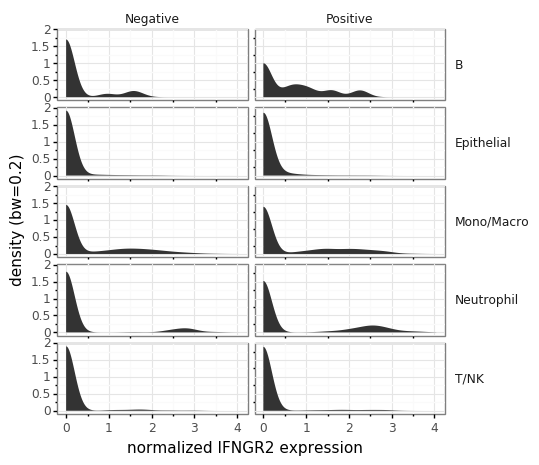

<ggplot: (8728164351217)>
label,stat,pval,adj_pval
Neutrophil,340269.5,4.192879078389239e-09,2.0964395391946198e-08
Epithelial,10627004.5,1.2653687674273748e-15,6.326843837136874e-15
Mono/Macro,9090625.0,4.604751247707305e-05,0.00023023756238536524
T/NK,325527.5,0.49645526360353687,1.0
B,275.5,0.020986611493155696,0.10493305746577848


In [44]:
goi = 'IFNGR2'
sc.pl.umap(hq_adata, 
           color=[goi,'leiden_1_class','patientID_415-xxxx'], 
           cmap='jet',
           ncols=1,
            
          )

_,df = prepare_dataframe(hq_adata,
                         hq_adata.var_names,
                         'leiden_1_class'
                        )
df = (df
      .loc[:, [goi]]
      .reset_index()
     )
df['SARScoV2qPCR'] = hq_adata.obs['SARScoV2qPCR'].values
df = df.query('leiden_1_class != "LowQuality"')


bw = 0.2
iters = 1000
y_max = np.max(df[goi].values)
x_grid = np.linspace(0, y_max, iters)

# cell type density
results_df = pd.DataFrame({'xval':x_grid})
for label in set(df['leiden_1_class']):
    x = df.query(f'leiden_1_class == "{label}"')[goi].values
    est = kde_scipy(x, x_grid, bandwidth=bw)
    results_df[label] = est
results_df = pd.melt(results_df, id_vars='xval')

plotnine.options.figure_size = (5,5)
plot = (ggplot(results_df)
        + theme_bw()
        + theme(strip_background=element_blank(),
                strip_text_y=element_text(angle=0, hjust=0)
               )
        + geom_area(aes('xval','value'), stat='identity')
        + facet_grid('variable~.')
        + ylab(f'density (bw={bw})')
        + xlab(f'normalized {goi} expression')
       )
print(plot)

# cell type by cov2_test density
results_df = pd.DataFrame()
for test in ['Positive', 'Negative']:
    for label in set(df['leiden_1_class']):
        x = df.query(f'SARScoV2qPCR == "{test}"').query(f'leiden_1_class == "{label}"')[goi].values
        est = kde_scipy(x, x_grid, bandwidth=bw)
        df_slice = pd.DataFrame({'xval':x_grid,
                                 'value':est})
        df_slice['variable'] = label
        df_slice['SARScoV2qPCR'] = test
        results_df = results_df.append(df_slice, ignore_index=True)

plotnine.options.figure_size = (5,5)
plot = (ggplot(results_df)
        + theme_bw()
        + theme(strip_background=element_blank(),
                strip_text_y=element_text(angle=0, hjust=0)
               )
        + geom_area(aes('xval','value'), stat='identity')
        + facet_grid('variable~SARScoV2qPCR')
        + ylab(f'density (bw={bw})')
        + xlab(f'normalized {goi} expression')
       )
print(plot)

# wilcoxon stats
stats = []
pvals = []
labs = []
for label in set(df['leiden_1_class']):
    pos_val = (df
               .query(f'leiden_1_class == "{label}"')
               .query(f'SARScoV2qPCR == "Positive"')[goi]
               .values
              )
    neg_val = (df
               .query(f'leiden_1_class == "{label}"')
               .query(f'SARScoV2qPCR == "Negative"')[goi]
               .values
              )
    if all(pos_val == 0) and all(neg_val == 0):
        stat,pval = np.nan, np.nan
    else:
        stat,pval = ss.mannwhitneyu(pos_val, neg_val, alternative='two-sided')

        
    stats.append(stat)
    pvals.append(pval)
    labs.append(label)
    
stats_df= pd.DataFrame({'label':labs,
                        'stat':stats,
                        'pval':pvals,
                       })
stats_df['adj_pval'] =  [x*len(stats_df) for x in stats_df['pval']]
stats_df['adj_pval'] =  [1 if x>1 else x for x in stats_df['adj_pval']]
stats_df.to_csv(sys.stdout, index=False)